In [1]:
!pip install kaggle

In [8]:
import tensorflow as tf

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)

model.evaluate(x_test,  y_test, verbose=2)

Epoch 1/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2989 - accuracy: 0.9133
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1456 - accuracy: 0.9567
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1103 - accuracy: 0.9664
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0878 - accuracy: 0.9728
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0749 - accuracy: 0.9765
313/313 - 1s - loss: 0.0820 - accuracy: 0.9756 - 733ms/epoch - 2ms/step


[0.0819803848862648, 0.975600004196167]

In [2]:
#!unzip -uq "train.zip" -d "content/train/"
!unzip train.zip -d /content/train

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/train/train/ce31f66a9991f1f2bb45b84b5a7bd6e7.jpg  
  inflating: /content/train/__MACOSX/train/._ce31f66a9991f1f2bb45b84b5a7bd6e7.jpg  
  inflating: /content/train/train/28f673b778e6f4cb974dc332fcb1ee1d.jpg  
  inflating: /content/train/__MACOSX/train/._28f673b778e6f4cb974dc332fcb1ee1d.jpg  
  inflating: /content/train/train/d25a5f80d6980ae97d2941913fc1ddd6.jpg  
  inflating: /content/train/__MACOSX/train/._d25a5f80d6980ae97d2941913fc1ddd6.jpg  
  inflating: /content/train/train/82d8cd7ee08ea0d65a6ee61da1520a73.jpg  
  inflating: /content/train/__MACOSX/train/._82d8cd7ee08ea0d65a6ee61da1520a73.jpg  
  inflating: /content/train/train/55132cf806d48347350caa4a31f0126b.jpg  
  inflating: /content/train/__MACOSX/train/._55132cf806d48347350caa4a31f0126b.jpg  
  inflating: /content/train/train/ac8869ca8acc2334a3e034c4ad8d0b68.jpg  
  inflating: /content/train/__MACOSX/train/._ac8869ca8acc2334a3e034c4ad8d0b68.jpg  
  inflating: /content/

In [11]:
import pandas as pd
label_text = pd.read_csv('/content/labels.csv')
print(label_text.head())
label_text.info()

                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


In [7]:
from tensorflow.keras.applications import MobileNetV2
mobilev2 = MobileNetV2()

In [9]:
import numpy as np
import tensorflow as tf

for layer in mobilev2.layers[:-1]:
    layer.trainable = True
    
for layer in mobilev2.layers[:-1]: 
    if 'kernel' in layer.__dict__:
        kernel_shape = np.array(layer.get_weights()).shape
        # weight를 평균이 0, 표준편차가 1인 random 변수로 초기화
        layer.set_weights(tf.random.normal(kernel_shape, 0, 1))

In [12]:
unique_Y = label_text['breed'].unique().tolist()
unique_sorted_Y = sorted(unique_Y)

In [13]:
x = mobilev2.layers[-2].output
predictions = tf.keras.layers.Dense(120, activation='softmax')(x)
model = tf.keras.Model(inputs=mobilev2.input, outputs=predictions)

model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [19]:
import os
import shutil

#os.mkdir('/content/train_sub')

for i in range(len(label_text)):
    if os.path.exists('/content/train_sub/' + label_text.loc[i]['breed']) == False:
        os.mkdir('/content/train_sub/' + label_text.loc[i]['breed'])
    shutil.copy('/content/train/train/' + label_text.loc[i]['id'] + '.jpg', '/content/train_sub/' + label_text.loc[i]['breed'])
# 8.25 ImageDataGenerator를 이용한 train/validation 데이터 분리, Image Augmentation
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_resnet_v2 import preprocess_input

image_size = 299
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255., horizontal_flip=True, shear_range=0.2, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, validation_split=0.25)
valid_datagen = ImageDataGenerator(rescale=1./255., validation_split=0.25)

train_generator = train_datagen.flow_from_directory(directory="/content/train_sub/", subset="training", batch_size=batch_size, seed=42, shuffle=True, class_mode="categorical", target_size=(image_size, image_size))
valid_generator = valid_datagen.flow_from_directory(directory="/content/train_sub/", subset="validation", batch_size=1, seed=42, shuffle=True, class_mode="categorical", target_size=(image_size, image_size))

Found 7718 images belonging to 120 classes.
Found 2504 images belonging to 120 classes.


In [33]:
import tensorflow_hub as hub

inception_url = 'https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4'
feature_model = tf.keras.Sequential([
    hub.KerasLayer(inception_url, output_shape=(2048,), trainable=False)
])
feature_model.build([None, 299, 299, 3])
feature_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
Total params: 21,802,784
Trainable params: 0
Non-trainable params: 21,802,784
_________________________________________________________________


In [15]:
import PIL.Image as Image
import matplotlib.pyplot as plt

import cv2
import random
plt.figure(figsize=(16,16))
  
for c in range(3):
    image_path = random.choice(valid_generator.filepaths)
    
    # 이미지 표시
    plt.subplot(3,2,c*2+1)
    plt.imshow(plt.imread(image_path))
    real_y = image_path.split('/')[3]
    plt.title(real_y)
    plt.axis('off')
    #idx = unique_sorted_Y.index(real_y)
    
    # 예측값 표시
    plt.subplot(3,2,c*2+2)
    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize=(299, 299))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    
    # Inception V3를 이용한 특징 벡터 추출
    feature_vector = feature_model.predict(img)
    
    # Sequential 모델을 이용한 예측
    prediction = model.predict(feature_vector)[0]
    
    # 가장 높은 확률의 예측값 5개를 뽑음
    top_5_predict = prediction.argsort()[::-1][:5]
    labels = [unique_sorted_Y[index] for index in top_5_predict]
    color = ['gray'] * 5
    #if idx in top_5_predict:
        #color[top_5_predict.tolist().index(idx)] = 'green'
    color = color[::-1]
    plt.barh(range(5), prediction[top_5_predict][::-1] * 100, color=color)
    plt.yticks(range(5), labels[::-1])

NameError: ignored

<Figure size 1152x1152 with 0 Axes>

In [16]:
unique_Y = label_text['breed'].unique().tolist()
train_Y = [unique_Y.index(breed) for breed in label_text['breed']]
train_Y = np.array(train_Y)

print(train_Y[:10])
print(train_Y[-10:])

[0 1 2 3 4 5 5 6 7 8]
[34 87 91 63 48  6 93 63 77 92]


In [17]:
x = mobilev2.layers[-2].output
predictions = tf.keras.layers.Dense(120, activation='softmax')(x)
model = tf.keras.Model(inputs=mobilev2.input, outputs=predictions)

model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [ ]:
steps_per_epoch = int(7718/32)
# generator를 사용하기 때문에 1epoch 당 학습할 step수를 정한다. batch_size인 32로 train_data의 크기를 나눈다.
history = model.fit_generator(train_generator, validation_data=valid_generator, epochs=10, steps_per_epoch=steps_per_epoch)
# model.fit_generator()를 사용한다.

In [20]:
from tensorflow.keras.applications import MobileNetV2
mobilev2 = MobileNetV2()

x = mobilev2.layers[-2].output
predictions = tf.keras.layers.Dense(120, activation='softmax')(x)
model = tf.keras.Model(inputs=mobilev2.input, outputs=predictions)

# 뒤에서 20개까지의 레이어는 훈련 가능, 나머지는 가중치 고정
for layer in model.layers[:-20]:
    layer.trainable = False
for layer in model.layers[-20:]:
    layer.trainable = True

model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [21]:
steps_per_epoch = int(7718/32)
# generator를 사용하기 때문에 1epoch 당 학습할 step수를 정한다. batch_size인 32로 train_data의 크기를 나눈다.
history = model.fit_generator(train_generator, validation_data=valid_generator, epochs=10, steps_per_epoch=steps_per_epoch)
# model.fit_generator()를 사용한다.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/10
241/241 [==============================] - 231s 907ms/step - loss: 3.3053 - accuracy: 0.3192 - val_loss: 1.7107 - val_accuracy: 0.5931
Epoch 2/10
241/241 [==============================] - 214s 888ms/step - loss: 1.5616 - accuracy: 0.6500 - val_loss: 1.1901 - val_accuracy: 0.6933
Epoch 3/10
241/241 [==============================] - 213s 885ms/step - loss: 1.1518 - accuracy: 0.7171 - val_loss: 1.0122 - val_accuracy: 0.7256
Epoch 4/10
241/241 [==============================] - 212s 879ms/step - loss: 0.9660 - accuracy: 0.7547 - val_loss: 0.9561 - val_accuracy: 0.7320
Epoch 5/10
241/241 [==============================] - 210s 872ms/step - loss: 0.8463 - accuracy: 0.7804 - val_loss: 0.8997 - val_accuracy: 0.7584
Epoch 6/10
241/241 [==============================] - 211s 875ms/step - loss: 0.7646 - accuracy: 0.8090 - val_loss: 0.8366 - val_accuracy: 0.7600
Epoch 7/10
241/241 [==============================] - 209s 867ms/step - loss: 0.7101 - accuracy: 0.8186 - val_loss: 0.8311 -

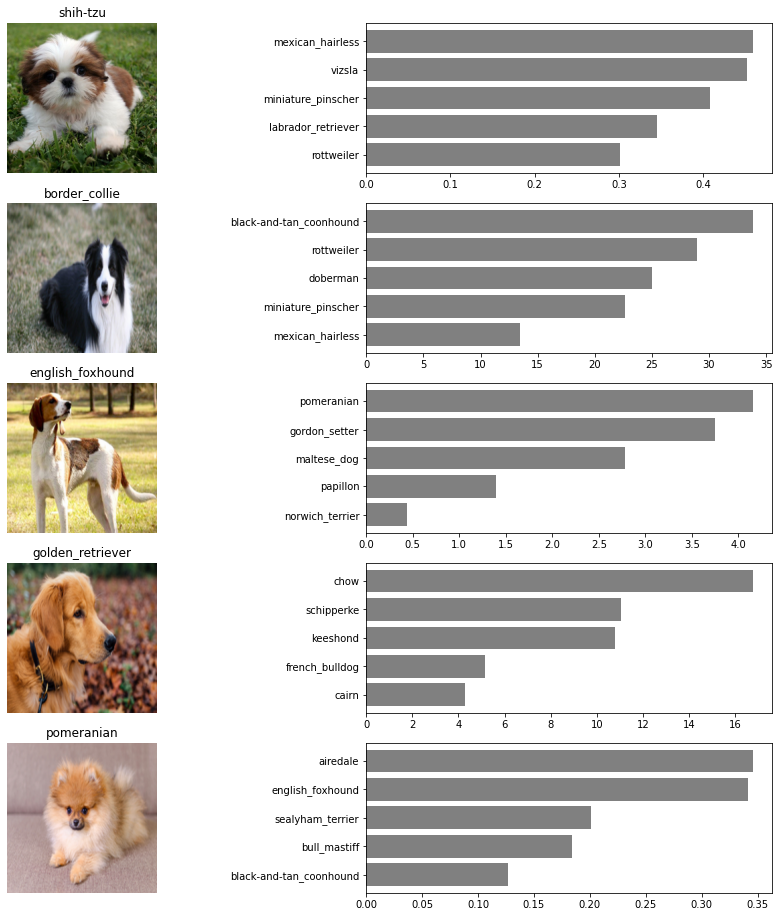

In [35]:
import cv2
import random
import PIL.Image as Image
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(16,16))

all_image_path = []
test_label = ['shih-tzu', 'border_collie', 'english_foxhound', 'golden_retriever', 'pomeranian']

for i in range(5):
    image_name = str(i+1)
    one_image_path = '/content/' + image_name + '.png'
    all_image_path.append(one_image_path)
    
for c in range(5):
    image_path = all_image_path[c]
    
    plt.subplot(5,2,c*2+1)
    plt.imshow(plt.imread(image_path))
    plt.title(test_label[c])
    plt.axis('off')
    
    plt.subplot(5,2,c*2+2)
    img = cv2.imread(image_path)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    
    prediction = model.predict(img)
    
    top_5_predict = prediction.argsort()[::-1][:5]
    new_top_5_predict = []
    for i in range(5):
      new_top_5_predict.append(top_5_predict[0][i])
    top_5_predict = new_top_5_predict

    labels = [unique_sorted_Y[index] for index in top_5_predict]
    color = ['gray'] * 5
    if test_label[c] in top_5_predict:
        color[top_5_predict.tolist().index(test_label[c])] = 'green'
    color = color[::-1]
    plt.barh(range(5), prediction[0][top_5_predict] * 100, color=color)
    plt.yticks(range(5), labels[::-1])